## 1. Import packages

In [279]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import os
import os.path as osp

# pytorch packages
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.nn.functional as F

from tqdm.auto import tqdm


## 2. Data loading and preprocessing

In [280]:

data_root = '/home/sh2439/pytorch_tutorials/pytorch_notebooks/data'
datasets = dsets.MNIST(root = data_root,
                      transform = transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize([0.5],[0.5])
                      ]),
                      train = True)

**Show the MNIST sample images**

torch.Size([1, 28, 28])


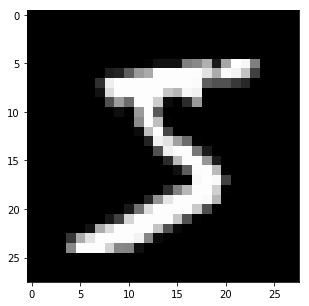

In [292]:
a = datasets[0][0]

def show(img):
    """Given the image tensor, show the gray image.
    """
    img = img.view(28,28)
    plt.figure(figsize=(5,5))
    plt.imshow(img,cmap = 'gray')
    plt.show()
    return

def show_grid(images, title = None, rows = 4):
    """Given the images tensors, show the multiple images
    """
    num = images.size(0)
    
    fig = plt.figure(figsize= (5,5))
    plt.title(title)
    cols = int(num/rows)
    
    for i in range(1, num+1):
        img = images[i-1].view(28,28)
        fig.add_subplot(rows, cols, i)
        plt.axis('off')
        plt.imshow(img, cmap = 'gray')
    
    plt.show()
    return

print(a.size())
show(a)



**Make the dataset iterable**

In [293]:
batch_size = 100
data_loader = torch.utils.data.DataLoader(dataset = datasets,
                                         batch_size = batch_size ,
                                         shuffle = True)

num_batches = int(len(datasets)/batch_size)
print('Batch size :{}, number of batches in one epoch :{}'.format(batch_size, num_batches))


Batch size :100, number of batches in one epoch :600


## 3. Build Network Class

**Build the discriminator network, 3 layers**

In [294]:
### Build the discriminator network
class Dis(nn.Module):
    
    def __init__(self):
        super(Dis,self ).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(1024,512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.layer3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.layer_out = nn.Linear(256,1)
        
    def forward(self, x):
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = F.sigmoid(self.layer_out(x))
        
        return x
        
            

**Build the generator network**

In [317]:
### Build the generator network
class Gen(nn.Module):
    
    def __init__(self):
        super(Gen,self).__init__()
        
        self.num_features = 100
        
        self.layer1 = nn.Sequential(
            nn.Linear(self.num_features, 256),
            nn.LeakyReLU(0.2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(256,512),
            nn.LeakyReLU(0.2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        
        )
        
        self.layer_out = nn.Sequential(
            nn.Linear(1024, 784),
            nn.Tanh()
        )
        
    def forward(self, x):

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer_out(x)

        return x

**Instantiate the model class**  
**Put the models to GPU if CUDA is available**

In [318]:
### Instantiate the model class
Dis_model = Dis()
Gen_model = Gen()

### Put the model to the gpu if possible
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if torch.cuda.device_count() > 1:
    Dis_model = nn.DataParallel(Dis_model).cuda()
    Gen_model = nn.DataParallel(Gen_model).cuda()
    
    torch.backends.cudnn.benchmark = True
    
Dis_model.to(device)
Gen_model.to(device)

print('The structure of discriminator:\n',Dis_model, '\nThe structure of generator:\n',Gen_model)

The structure of discriminator:
 DataParallel(
  (module): Dis(
    (layer1): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Dropout(p=0.3)
    )
    (layer2): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Dropout(p=0.3)
    )
    (layer3): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Dropout(p=0.3)
    )
    (layer_out): Linear(in_features=256, out_features=1, bias=True)
  )
) 
The structure of generator:
 DataParallel(
  (module): Gen(
    (layer1): Sequential(
      (0): Linear(in_features=100, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (layer2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (layer3): Sequential(
      (0):

## 4. Loss and optimizer

In [319]:
dis_optimizer = torch.optim.Adam(Dis_model.parameters(), lr = 0.0002)
gen_optimizer = torch.optim.Adam(Gen_model.parameters(), lr = 0.0002)

criterion = nn.BCELoss()




## 5. Train the model

**Helper functions to generate real data and fake data labels**

In [320]:
def real_label(real_data):
    """Generate real data labels
    """
    num = real_data.size(0)
    labels = Variable(torch.ones(num,1)).to(device)
    
    return labels

def fake_label(fake_data):
    """Generate fake data labels
    """
    num = fake_data.size(0)
    labels = Variable(torch.zeros(num,1)).to(device)
    
    return labels

**Helper functions to train the discriminator and generator**

In [321]:


def train_dis(model,optimizer, real_data, fake_data):
    
    optimizer.zero_grad()
    
    # train on real data
    real_preds = model(real_data)
    loss_real = criterion(real_preds, real_label(real_data))
    loss_real.backward()
    
    # train on fake data
    fake_preds = model(fake_data)
    loss_fake = criterion(fake_preds, fake_label(fake_data))
    loss_fake.backward()
    
    loss_D = loss_real + loss_fake
    # update
    optimizer.step()
    
    return loss_D, real_preds, fake_preds
    
def train_gen(model, optimizer, fake_data):
    
    # reset optimizer
    optimizer.zero_grad()
    
    # sample noise and generate fake_data
    preds = model(fake_data)
    
    loss = criterion(preds, real_label(preds))
    loss.backward()

    optimizer.step()
    return loss,preds
    
    

**Generate samples for training**

In [322]:
def noise(size):
    n = Variable(torch.randn(size, 100)).to(device)
    return n

num_test_samples = 16
test_noise = noise(num_test_samples)
    

**Start training**  
**Show the generated images every 20 epochs**

epoch:0, iters:599, loss_D:1.4850395917892456, loss_G:1.353416085243225
D(x):0.6477670073509216, D(G(z1)):0.4824220836162567, D(G(z2):0.3563908040523529)


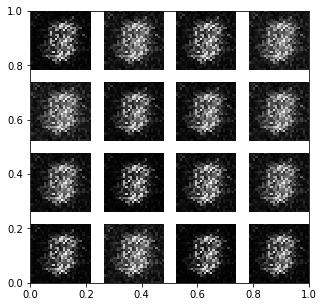

epoch:1, iters:1199, loss_D:0.5142305493354797, loss_G:2.2575812339782715
D(x):0.7732079029083252, D(G(z1)):0.19261008501052856, D(G(z2):0.13294008374214172)
epoch:2, iters:1799, loss_D:0.930299699306488, loss_G:1.351951241493225
D(x):0.7618984580039978, D(G(z1)):0.3713468909263611, D(G(z2):0.3038717210292816)
epoch:3, iters:2399, loss_D:0.8075757026672363, loss_G:2.4746146202087402
D(x):0.7856289744377136, D(G(z1)):0.19344793260097504, D(G(z2):0.13671550154685974)
epoch:4, iters:2999, loss_D:0.4358493685722351, loss_G:1.756226658821106
D(x):0.8683499097824097, D(G(z1)):0.2201583832502365, D(G(z2):0.20789195597171783)
epoch:5, iters:3599, loss_D:0.5772119760513306, loss_G:1.5265141725540161
D(x):0.8089073896408081, D(G(z1)):0.2059411257505417, D(G(z2):0.26970213651657104)
epoch:6, iters:4199, loss_D:1.2042145729064941, loss_G:1.188955545425415
D(x):0.6605055332183838, D(G(z1)):0.361631840467453, D(G(z2):0.3641386330127716)
epoch:7, iters:4799, loss_D:0.6709165573120117, loss_G:1.741742

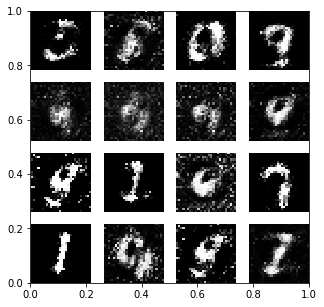

epoch:11, iters:7199, loss_D:0.6331048607826233, loss_G:1.634933590888977
D(x):0.796303927898407, D(G(z1)):0.24974334239959717, D(G(z2):0.24019427597522736)
epoch:12, iters:7799, loss_D:1.1856255531311035, loss_G:1.5570544004440308
D(x):0.6188241243362427, D(G(z1)):0.2917064130306244, D(G(z2):0.3141637444496155)
epoch:13, iters:8399, loss_D:0.9735705852508545, loss_G:1.404628872871399
D(x):0.7712467312812805, D(G(z1)):0.3264549672603607, D(G(z2):0.3484173119068146)
epoch:14, iters:8999, loss_D:0.6233224868774414, loss_G:1.8208856582641602
D(x):0.8452000021934509, D(G(z1)):0.2718898057937622, D(G(z2):0.2242029309272766)
epoch:15, iters:9599, loss_D:1.0431702136993408, loss_G:1.5871962308883667
D(x):0.706082284450531, D(G(z1)):0.30529680848121643, D(G(z2):0.2941459119319916)
epoch:16, iters:10199, loss_D:0.8938419222831726, loss_G:1.6179753541946411
D(x):0.7314404845237732, D(G(z1)):0.317940354347229, D(G(z2):0.2694453001022339)
epoch:17, iters:10799, loss_D:0.8238611817359924, loss_G:1.

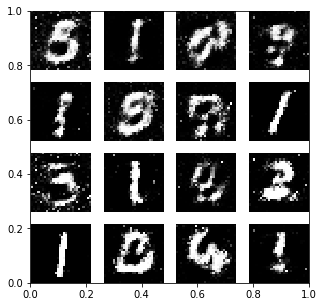

epoch:21, iters:13199, loss_D:0.8476235270500183, loss_G:1.8726402521133423
D(x):0.6295955181121826, D(G(z1)):0.23106741905212402, D(G(z2):0.2037833034992218)
epoch:22, iters:13799, loss_D:0.9055212736129761, loss_G:1.649346947669983
D(x):0.705075204372406, D(G(z1)):0.30883273482322693, D(G(z2):0.2644321620464325)
epoch:23, iters:14399, loss_D:0.7411030530929565, loss_G:1.6474131345748901
D(x):0.7586169838905334, D(G(z1)):0.2699654996395111, D(G(z2):0.27505531907081604)
epoch:24, iters:14999, loss_D:1.0833333730697632, loss_G:1.3469061851501465
D(x):0.7268003821372986, D(G(z1)):0.406171977519989, D(G(z2):0.3280428946018219)
epoch:25, iters:15599, loss_D:0.9461874961853027, loss_G:1.3216699361801147
D(x):0.6941545605659485, D(G(z1)):0.35366126894950867, D(G(z2):0.33038458228111267)
epoch:26, iters:16199, loss_D:1.0103425979614258, loss_G:1.4126843214035034
D(x):0.695378839969635, D(G(z1)):0.34590765833854675, D(G(z2):0.32279661297798157)
epoch:27, iters:16799, loss_D:1.186481237411499, 

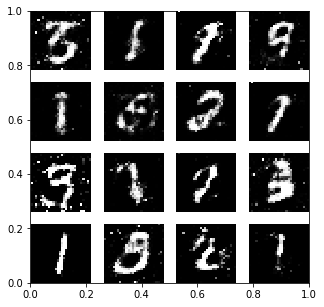

epoch:31, iters:19199, loss_D:1.0078003406524658, loss_G:1.5795384645462036
D(x):0.6737110614776611, D(G(z1)):0.3470432162284851, D(G(z2):0.2873886525630951)
epoch:32, iters:19799, loss_D:1.067213535308838, loss_G:1.2589954137802124
D(x):0.6430169343948364, D(G(z1)):0.3439326286315918, D(G(z2):0.3574817478656769)
epoch:33, iters:20399, loss_D:1.1433454751968384, loss_G:1.3305902481079102
D(x):0.6910670399665833, D(G(z1)):0.4368489682674408, D(G(z2):0.31989502906799316)
epoch:34, iters:20999, loss_D:1.0508188009262085, loss_G:1.2032188177108765
D(x):0.7029879689216614, D(G(z1)):0.4073256552219391, D(G(z2):0.3461077809333801)
epoch:35, iters:21599, loss_D:1.0125898122787476, loss_G:1.243422031402588
D(x):0.6441017985343933, D(G(z1)):0.3700489103794098, D(G(z2):0.338082492351532)
epoch:36, iters:22199, loss_D:1.2087161540985107, loss_G:1.0867232084274292
D(x):0.5792081952095032, D(G(z1)):0.37759271264076233, D(G(z2):0.3785804808139801)
epoch:37, iters:22799, loss_D:1.4005916118621826, los

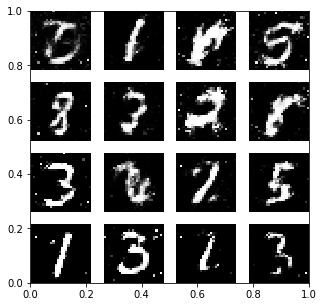

epoch:41, iters:25199, loss_D:0.9875317215919495, loss_G:1.2550194263458252
D(x):0.6478636264801025, D(G(z1)):0.33538320660591125, D(G(z2):0.33485156297683716)
epoch:42, iters:25799, loss_D:1.065864086151123, loss_G:1.1611127853393555
D(x):0.6265957355499268, D(G(z1)):0.3670639395713806, D(G(z2):0.35320356488227844)
epoch:43, iters:26399, loss_D:1.1392258405685425, loss_G:1.4163397550582886
D(x):0.6450778841972351, D(G(z1)):0.37042179703712463, D(G(z2):0.2980503439903259)
epoch:44, iters:26999, loss_D:1.065990924835205, loss_G:1.168260097503662
D(x):0.619584858417511, D(G(z1)):0.3488089144229889, D(G(z2):0.3516373634338379)
epoch:45, iters:27599, loss_D:1.2308931350708008, loss_G:1.2581965923309326
D(x):0.5247668623924255, D(G(z1)):0.3500518798828125, D(G(z2):0.344967782497406)
epoch:46, iters:28199, loss_D:0.9930302500724792, loss_G:1.2548165321350098
D(x):0.6714752316474915, D(G(z1)):0.3572711944580078, D(G(z2):0.3353194296360016)
epoch:47, iters:28799, loss_D:1.131072998046875, loss

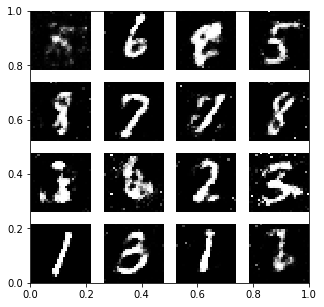

epoch:51, iters:31199, loss_D:1.0870692729949951, loss_G:1.1215413808822632
D(x):0.5666993856430054, D(G(z1)):0.3285691738128662, D(G(z2):0.366441935300827)
epoch:52, iters:31799, loss_D:1.265221357345581, loss_G:1.3217049837112427
D(x):0.5574630498886108, D(G(z1)):0.36265119910240173, D(G(z2):0.3293178379535675)
epoch:53, iters:32399, loss_D:1.2258307933807373, loss_G:0.9675804972648621
D(x):0.5766521096229553, D(G(z1)):0.4260082244873047, D(G(z2):0.4074722230434418)
epoch:54, iters:32999, loss_D:1.1441845893859863, loss_G:1.280799150466919
D(x):0.621617317199707, D(G(z1)):0.41017448902130127, D(G(z2):0.31992262601852417)
epoch:55, iters:33599, loss_D:1.127807855606079, loss_G:0.991936206817627
D(x):0.6071131825447083, D(G(z1)):0.4036714434623718, D(G(z2):0.4016551971435547)
epoch:56, iters:34199, loss_D:1.2633553743362427, loss_G:1.029935359954834
D(x):0.5592907667160034, D(G(z1)):0.4153982102870941, D(G(z2):0.40075790882110596)
epoch:57, iters:34799, loss_D:1.1941981315612793, loss_

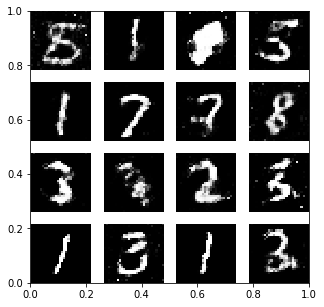

epoch:61, iters:37199, loss_D:1.1751477718353271, loss_G:0.9974838495254517
D(x):0.5734132528305054, D(G(z1)):0.39823290705680847, D(G(z2):0.4060472846031189)
epoch:62, iters:37799, loss_D:1.1248881816864014, loss_G:1.0257766246795654
D(x):0.6288626790046692, D(G(z1)):0.41306933760643005, D(G(z2):0.3882027268409729)
epoch:63, iters:38399, loss_D:1.226495623588562, loss_G:0.9868139624595642
D(x):0.5540546774864197, D(G(z1)):0.39636892080307007, D(G(z2):0.42189207673072815)
epoch:64, iters:38999, loss_D:1.3744173049926758, loss_G:1.0660443305969238
D(x):0.5644689798355103, D(G(z1)):0.44250723719596863, D(G(z2):0.3807152509689331)
epoch:65, iters:39599, loss_D:1.0806268453598022, loss_G:1.027158260345459
D(x):0.6306240558624268, D(G(z1)):0.4000933766365051, D(G(z2):0.3999282717704773)
epoch:66, iters:40199, loss_D:1.2284923791885376, loss_G:0.8779089450836182
D(x):0.5912950038909912, D(G(z1)):0.43036243319511414, D(G(z2):0.458117812871933)
epoch:67, iters:40799, loss_D:1.2287054061889648,

KeyboardInterrupt: 

In [324]:
num_epochs = 200

for epoch in tqdm(range(num_epochs)):
    
    for batch_idx, (real_images, _) in enumerate(data_loader):
        
        ### 1. Train the discriminator
        real_images = Variable(real_images.view(-1,28*28)).to(device)
        
        #generate the fake data
        fake_images = Gen_model(noise(real_images.size(0))).detach()
        
        # train the discriminator
        loss_D, real_preds, fake_preds = train_dis(Dis_model, dis_optimizer, real_images, fake_images)
        
        D_x = real_preds.mean().item()
        D_G1 = fake_preds.mean().item()
        
        ### 2. Train the generator
        fake_images = Gen_model(noise(real_images.size(0)))
        # train the generator
        loss_G, preds = train_gen(Dis_model, gen_optimizer, fake_images)
        
        D_G2 = preds.mean().item()
    
    # show the loss every epoch
    print('epoch:{}, iters:{}, loss_D:{}, loss_G:{}'.format(epoch, batch_idx +epoch*num_batches , loss_D.item(), loss_G.item()))
    print('D(x):{}, D(G(z1)):{}, D(G(z2):{})'.format(D_x, D_G1, D_G2))

    # show the test images every 10 epochs
    if epoch%10 ==0:
        test_imgs = Gen_model(test_noise).cpu().detach()
        show_grid(test_imgs)
    

torch.Size([784])


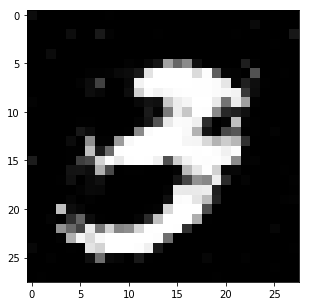

In [227]:
test_imgs = Gen_model(test_noise).cpu().detach()

# a = test_imgs[7].cpu().detach()
a = test_imgs[1]
print(a.size())
show(a)